# Initiate

In [1]:
import time
import os
import openai
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.spatial.distance import cosine, euclidean

openai.api_key = os.environ['OPENAI_API_KEY']
np.set_printoptions(precision=3, suppress=True)

REFRESH = False

def get_embedding(text, sleep=0):
    '''Compute GPT3-embedding for a given text string'''
    time.sleep(sleep)
    result = openai.Embedding.create(input=text, model='text-embedding-ada-002')
    return np.array(result.data[0].embedding)

# Get Dataframes

In [2]:
def glue(row):
    replacement_dict = {'Male': 'man', 'Female': 'woman'}
    row['Gender'] = replacement_dict.get(row['Gender'], 'John Cena')
    return ' '.join(row[['Lifestyle', 'Age', 'Race', 'Gender']].values).lower()

    
def get_df_likes_dislikes(
        attr,
        df_people,
        refresh
        ):
    if not refresh:
        raise Exception('API call aborted. Were you sure? If yes, change REFRESH to True.')
    df = pd.DataFrame()
    for i in df_people[['ID', 'Description', attr]].values:
        for like in i[2]:
            df = pd.concat(
                [
                    df,
                    pd.DataFrame(
                        [
                            i[0],
                            like.lower(),
                            f'{i[1]} who likes {like.lower()}'
                        ]
                    ).T
                ],
                axis='rows'
            )
    df.reset_index(inplace=True, drop=True)
    df.columns=['ID', 'Activity', 'Description']
    df['Embedding'] = df.Description.apply(lambda x: get_embedding(x))
    return df


def add_activity(df):
    df['Activity'] = np.stack(df.Description.str.split('who likes '))[:, 1]
    

def normalize(x, overall_min, overall_max):  # currently from -1 to 1 due to negative vectors (we center at 0)
    return 2 * (x - overall_min) / (overall_max - overall_min) - 1


def add_deviation(df):
    # first we find mean vector for an ID
    # only then we find the mean for likes/dislikes
    # thus we prevent individuals having too much likes/dislikes
    # from solely deciding the mean
    mean_vector = df\
    .groupby('ID')\
    .Embedding\
    .apply(lambda x: np.mean(np.stack(x), axis=0))\
    .mean()
    deviation = df.Embedding.apply(lambda x: x - mean_vector)
    df['Deviation'] = deviation
    overall = np.concatenate(df.Deviation)
    overall_min = np.min(overall)
    overall_max = np.max(overall)
    del overall
    norm_dev = df.Deviation.apply(lambda x: normalize(x, overall_min, overall_max))
    df['Norm_Dev'] = norm_dev

In [ ]:
path_test_vector = 'data/embeddings/test_vector'
if REFRESH:
    test_vector = get_embedding('test')
    np.save(path_test_vector, test_vector)
else:
    test_vector = np.load(
        f'{path_test_vector}.npy',
        allow_pickle=True
    )

In [176]:
df_people = pd.read_csv('./data/people.csv')
people = {}
person_id = 0
for person in list(df_people.items())[0][1]:
    person = person.replace('\r', '')
    person_list = [i.split(': ') for i in person.split('\n')]
    person_dict = {j[0]: j[1] for j in person_list}
    people[f'Person_{person_id}'] = person_dict
    person_id += 1
df_people = pd.DataFrame(people).T
df_people['Likes'] = df_people['Likes'].str.split(', ')
df_people['Dislikes'] = df_people['Dislikes'].str.split(', ')
df_people['Description'] = df_people.apply(
    lambda row: glue(row), axis='columns')
# df_people['Person_ID'] = df_people.index
df_people.head(1)

,Gender,Age,Race,Lifestyle,Likes,Dislikes,Description
Person_0,man,Young Adult,African American,Moderate,"[Sports, Outdoors, Learning, Exercise]","[Homemaking, Design, Relaxing, Arts and Crafts]",moderate young adult african american man


In [180]:
path_activities = 'data/embeddings/activities_embeddings.csv'
if REFRESH:
    activities = []
    for person in people.values():
        for attitude in ['Likes', 'Dislikes']:
            for activity in person[attitude].split(', '):
                if activity not in activities:
                    activities.append(activity)
    activities.sort()
    activities = {activity: get_embedding(activity) for activity in activities}
    df_activities = pd.DataFrame(activities)
    df_activities.to_csv(path_activities, index=False)
else:
    df_activities = pd.read_csv(path_activities)


In [144]:
def prepare(df):
    """
    center and normalize each point of the vector from -1 to 1
    compared to the neighbouring entities.
    Each feature inside of 1536 long-vector is normalized separately
    according to the observations of the same feature in other entities.
    """
    df_ = df.copy()
    mean = df_.mean(axis='columns')
    df_ = df_.apply(lambda column: column - mean, axis='rows')
    min_ = df_.apply(lambda row: row.min(), axis='columns')
    max_ = df_.apply(lambda row: row.max(), axis='columns')
    df_ = df_.apply(
        lambda column: 2 * (max_ - column) / (max_ - min_) - 1,
        axis='rows'
    )
    return df_

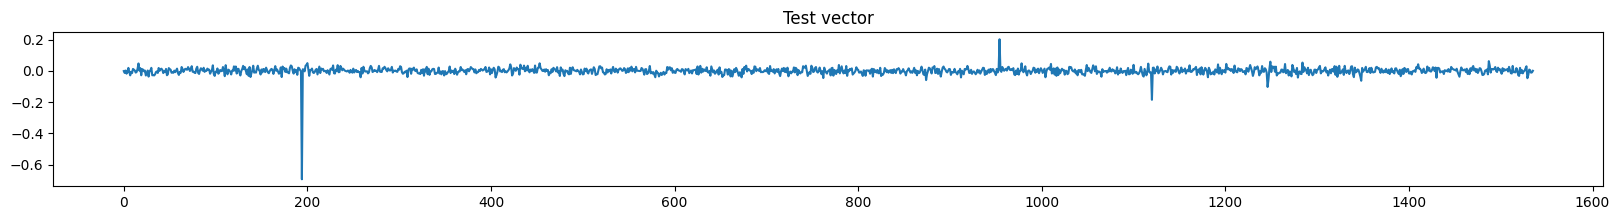

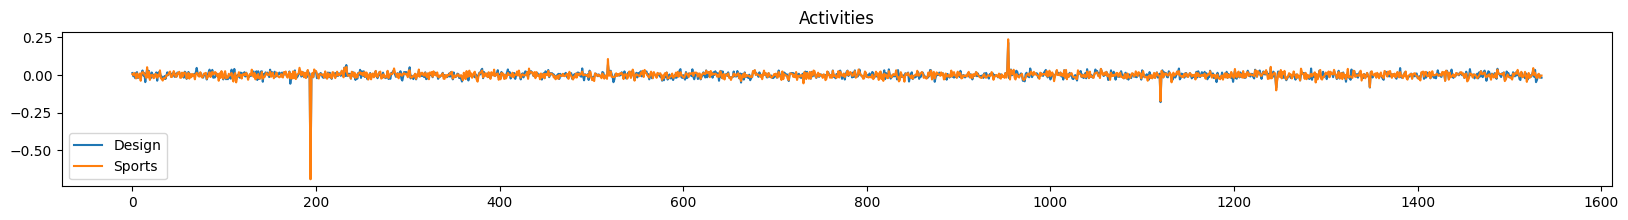

In [201]:
plt.figure(figsize=(20,2))
plt.plot(test_vector)
plt.title('Test vector')
plt.show()
plt.figure(figsize=(20,2))
plt.title('Activities')
# for activity in activities:
#     plt.plot(df_activities[activity], label=activity)
plt.plot(df_activities['Design'], label='Design')
plt.plot(df_activities['Sports'], label='Sports')
plt.legend()
plt.show()

In [157]:
df_activities = prepare(df_activities)

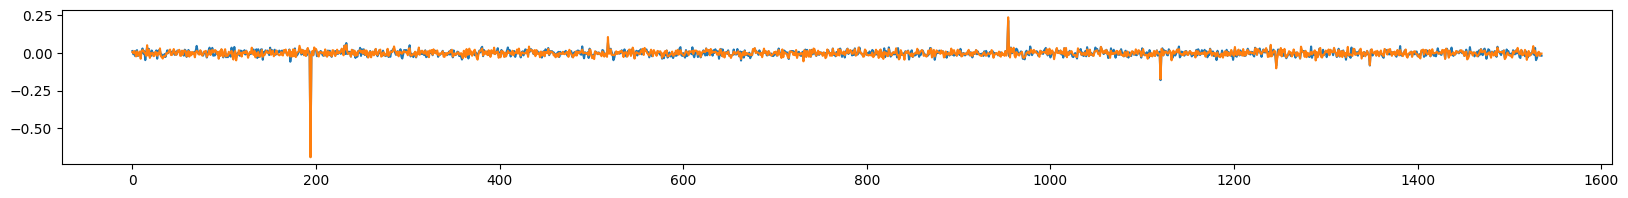

In [197]:
plt.figure(figsize=(20,2))
# for activity in activities:
#     plt.plot(df_activities[activity])
plt.plot(df_activities['Design'])
plt.plot(df_activities['Sports'])

In [159]:
path_people_descriptions = 'data/embeddings/people_descriptions_embeddings.csv'
if REFRESH:
    people_descriptions = {id: get_embedding(description) for id, description in zip(df_people.Person_ID, df_people.Description)}
    df_people_descriptions = pd.DataFrame(people_descriptions)
    df_people_descriptions.to_csv(path_people_descriptions, index=False)
else:
    df_people_descriptions = pd.read_csv(path_people_descriptions)


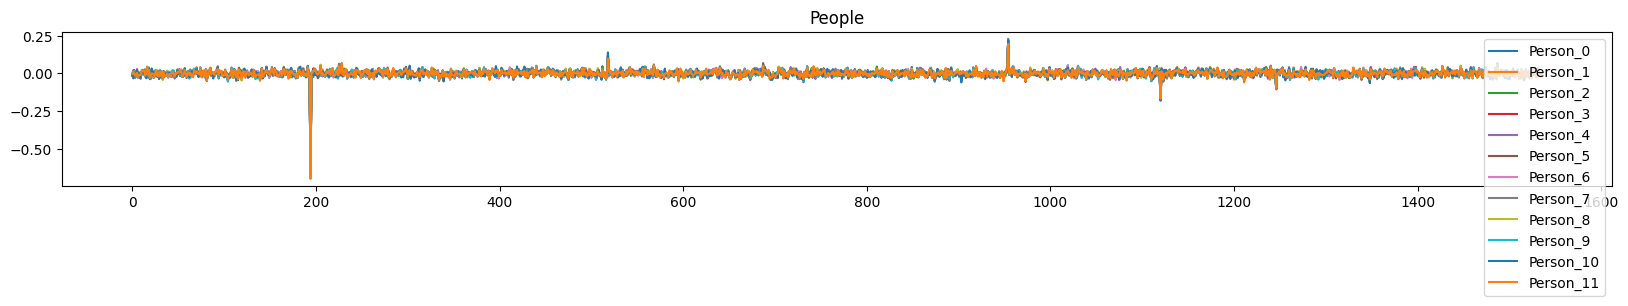

In [207]:
plt.figure(figsize=(20,2))
plt.title('People')
for person in people:
    plt.plot(df_people_descriptions[person], label=person)
plt.legend()
plt.show()

In [208]:
df_people_descriptions = prepare(df_people_descriptions)

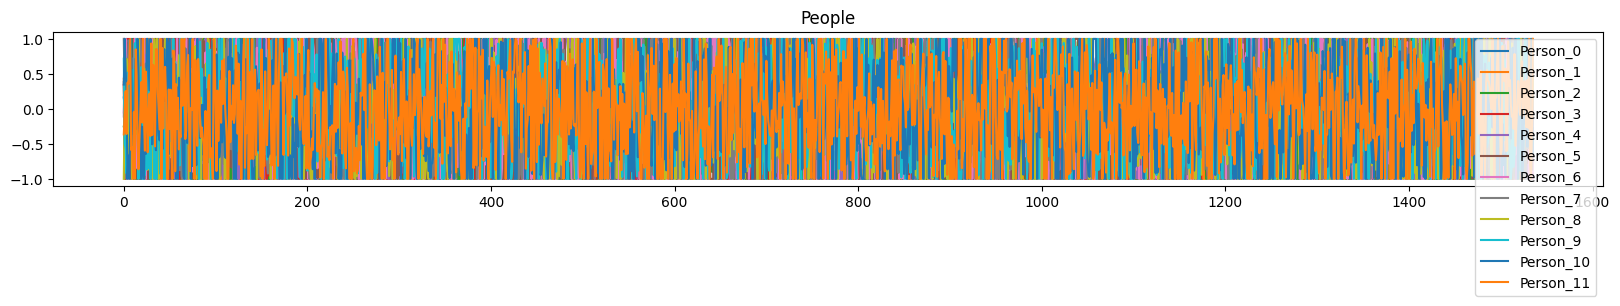

In [209]:
plt.figure(figsize=(20,2))
plt.title('People')
for person in people:
    plt.plot(df_people_descriptions[person], label=person)
plt.legend()
plt.show()